In [4]:
from metrics import SquaredError
from metrics.utils import post_process
from function_classes.wrappers import (
    ScaledXRegression,
    ScaledYRegression,
    NoisyXRegression,
    NoisyYRegression,
)


from models.linear import LeastSquaresModel
from models.zero_model import ZeroModel

from function_classes.linear import LinearRegression

from torch.distributions import MultivariateNormal
import torch

In [5]:
B_SIZE, SEQ_LEN, X_DIM, Y_DIM = 512, 20, 10, 1
X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

MODELS = [LeastSquaresModel(), ZeroModel()]

SCALES: list[float] = [0.125, 0.25, 0.5, 2., 4., 8.]
NOISE_LEVELS: list[float] = [0.0625, 0.125, 0.25, 0.5, 1.]

In [6]:
x_dist = MultivariateNormal(torch.zeros(X_SHAPE), torch.eye(X_DIM)) #batch size, sequence_length, x_dim

base_fc = LinearRegression(x_dist, y_dim=Y_DIM)

bench = SquaredError(function_class=base_fc)

In [10]:
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))

dict_keys(['accuracy', 'std', 'std_mean', 'max', 'min', 'confidence_0.01_upper', 'confidence_0.01_lower', 'confidence_0.05_upper', 'confidence_0.05_lower', 'quantile_0.05', 'quantile_0.25', 'quantile_0.5', 'quantile_0.75', 'quantile_0.95'])


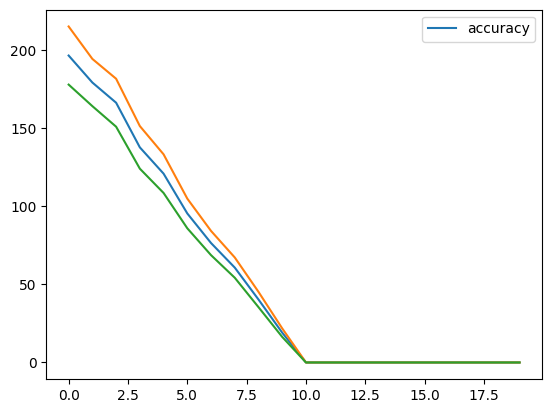

In [11]:
import matplotlib.pyplot as plt

for model, results in zip(MODELS, values):
    print(results.keys())
    plt.plot("accuracy", data=results, label="accuracy")
    plt.plot("confidence_0.01_upper", data=results)
    plt.plot("confidence_0.01_lower", data=results)
    plt.legend()
    plt.show()
    break


In [9]:
scaled_x_fcs = [
    ScaledXRegression(scale, base_fc)
    for scale in SCALES
]
scaled_in_benches = [SquaredError(fc) for fc in scaled_x_fcs]

scaled_y_fcs = [
    ScaledYRegression(scale, base_fc)
    for scale in SCALES
]
scaled_out_benches = [SquaredError(fc) for fc in scaled_y_fcs]

noisy_x_fcs = [
    NoisyXRegression(
        MultivariateNormal(
            torch.zeros(X_SHAPE), 
            noise_level * torch.eye(X_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_in_benches = [SquaredError(fc) for fc in noisy_x_fcs]

noisy_y_fcs = [
    NoisyYRegression(
        MultivariateNormal(
            torch.zeros(Y_SHAPE), 
            noise_level * torch.eye(Y_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_out_benches = [SquaredError(fc) for fc in noisy_y_fcs]

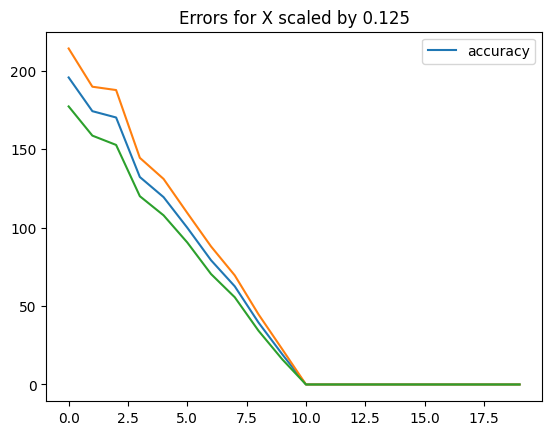

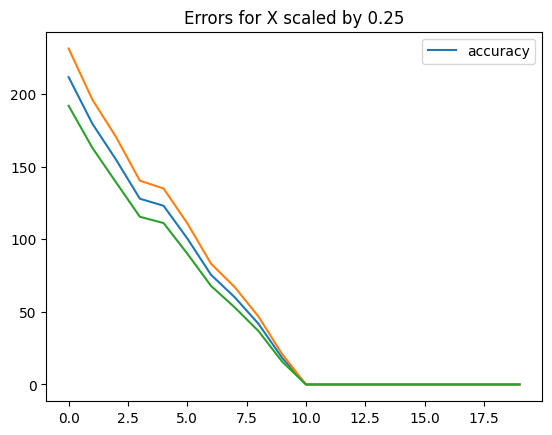

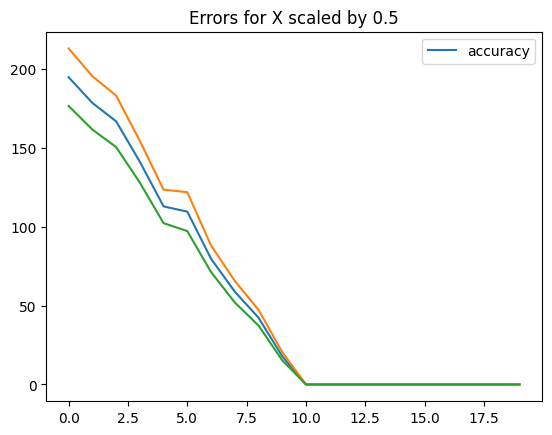

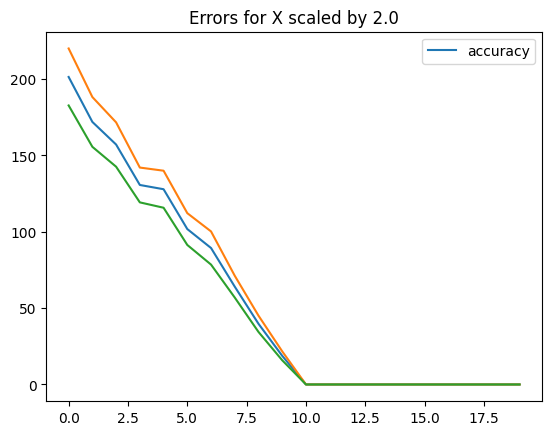

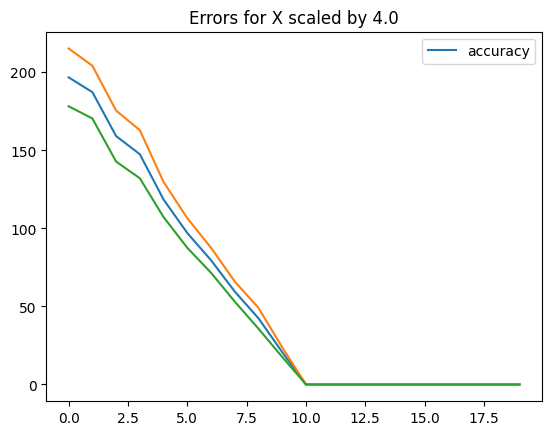

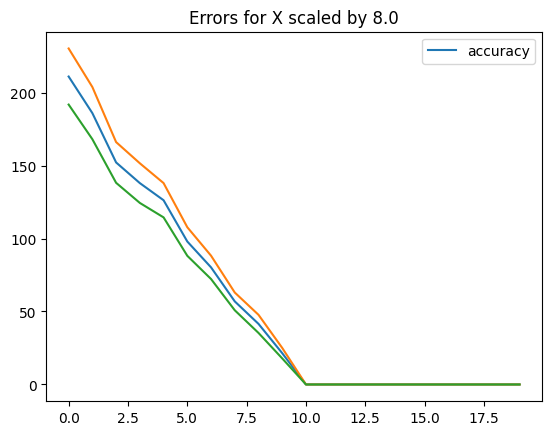

In [13]:
for b in scaled_in_benches:
    errs = b.evaluate(MODELS, num_batches=4)
    values = list(post_process(errs))
    for model, results in zip(MODELS, values):
        plt.title(f"Errors for X scaled by {b.fn_cls._scale}")  # pyright: ignore[reportAttributeAccessIssue]
        plt.plot("accuracy", data=results, label="accuracy")
        plt.plot("confidence_0.01_upper", data=results)
        plt.plot("confidence_0.01_lower", data=results)
        plt.legend()
        plt.show()
        break